<a href="https://colab.research.google.com/github/IMARTYI/COSC4P96-Assignment-1/blob/main/COSC4P96_A1_DavidMartin_6995948.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection and Preprocessing
 - Using Fashion-MNSIST Dataset
 - 10 Classes
 - Clothes Dataset


In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pds
import kagglehub
from torch.utils.data import Dataset, DataLoader, Subset, random_split, ConcatDataset
from sklearn.model_selection import train_test_split
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

# Downloading Dataset and Dataset statistics

Total Dataset Size: 70000
Train Size: 56000
Validation Size: 7000
Test Size: 7000
Training Set: 
Label 9: 5568 samples
Label 6: 5652 samples
Label 5: 5632 samples
Label 3: 5598 samples
Label 8: 5570 samples
Label 7: 5592 samples
Label 1: 5629 samples
Label 4: 5597 samples
Label 2: 5570 samples
Label 0: 5592 samples


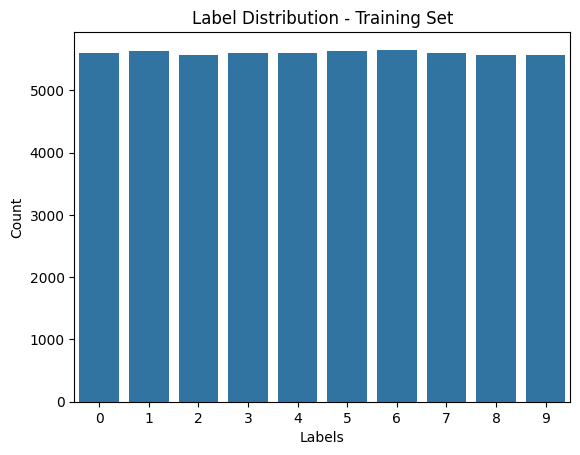

Minimum Pixel Value: 0.0
Maximum Pixel Value: 1.0
Mean Pixel Value: 0.2859440743923187
Standard Deviation: 0.3528888523578644
Validation Set: 
Label 9: 709 samples
Label 4: 696 samples
Label 1: 712 samples
Label 8: 692 samples
Label 6: 663 samples
Label 0: 708 samples
Label 2: 722 samples
Label 7: 702 samples
Label 3: 688 samples
Label 5: 708 samples


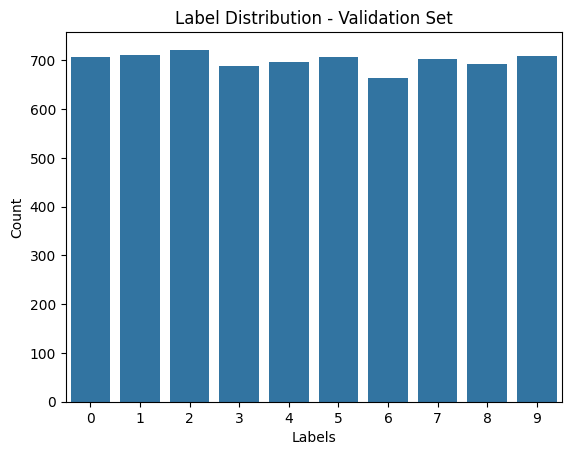

Minimum Pixel Value: 0.0
Maximum Pixel Value: 1.0
Mean Pixel Value: 0.28484046459198
Standard Deviation: 0.3519449830055237
Test Set: 
Label 3: 714 samples
Label 0: 700 samples
Label 9: 723 samples
Label 8: 738 samples
Label 1: 659 samples
Label 6: 685 samples
Label 5: 660 samples
Label 7: 706 samples
Label 4: 707 samples
Label 2: 708 samples


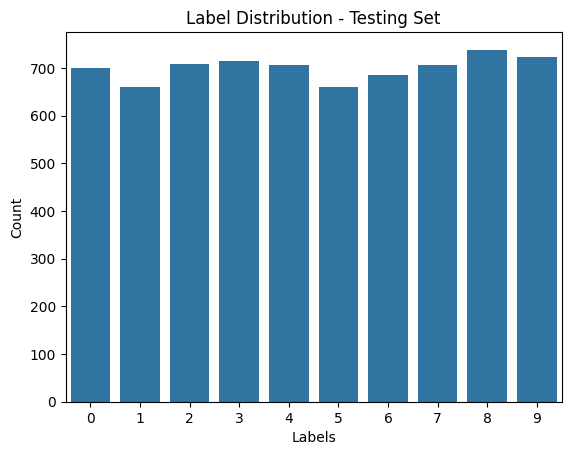

In [10]:
# Download Dataset
training_data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Ensure Data Split: 80% Train , 10% validation, 10% Test

full_dataset = ConcatDataset([training_data, test_set])

print(f"Total Dataset Size: {len(full_dataset)}")

# Ensure data split
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = int(0.1*len(full_dataset))

print(f"Train Size: {train_size}")
print(f"Validation Size: {val_size}")
print(f"Test Size: {test_size}")


SEED = 42 # Seeding project for repruduciability
torch.manual_seed(SEED)

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])


def label_distribution(data,dataset_name = "Dataset"):

  if not data:
    print(f"Dataset {dataset_name} is empty.")
    return

  first_item  = data [0]
  labels = []

  if isinstance(first_item,(tuple,list)):
    if len(first_item) == 2:
      labels = [x[1] for x in data]
    elif len(first_item) == 3:
      labels = [x[2] for x in data]
    else:
      return
  else:
    return

  counts = Counter(labels)

  for label, count in counts.items():
    print(f"Label {label}: {count} samples")
  labels_list = list(counts.keys())
  counts_list = list(counts.values())

  sns.barplot(x=labels_list, y=counts_list)
  plt.xlabel("Labels")
  plt.ylabel("Count")
  plt.title(f"Label Distribution - {dataset_name}")
  plt.show()


def feature_image_range(dataset):
  pixels = torch.cat([dataset[i][0].reshape(-1) for i in range(len(dataset))])

  print(f"Minimum Pixel Value: {pixels.min()}")
  print(f"Maximum Pixel Value: {pixels.max()}")
  print(f"Mean Pixel Value: {pixels.mean()}")
  print(f"Standard Deviation: {pixels.std()}")

# BEFORE DATA PREPROCESSING
print("Training Set: ")
label_distribution(train_set,"Training Set")
feature_image_range(train_set)
print("Validation Set: ")
label_distribution(val_set, "Validation Set")
feature_image_range(val_set)
print("Test Set: ")
label_distribution(test_set, "Testing Set")


# Labeled and unlabled. Training Pool Split And Data Augmentations

- 80% Unlabled
- 20% Labled

# Data Augemtations
- Horizontal Flip
- Random Image Cropping

In [11]:
from torchvision.datasets import imagenet
# Data Augmentations
BATCH_SIZE = 64
SEED = 42

# Augmentation for training and Data Preprocessing
data_augmentation_minmax = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), #
    transforms.RandomCrop(28,padding= 4),  # Shifts teach the model posistional variance
    # transforms.ToTensor()   # Scales to [0,1]
    ])


data_augmentation_zscore = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), #
    transforms.RandomCrop(28,padding= 4),  # Shifts teach the model posistional variance
    transforms.Normalize((0.286,), (0.353,)) # Normalizations given by Mean and Standard Deviation Pixel Values
    ])

# Used for Validation Set
transform_no_augmentations = transforms.Compose([ # No Use of Data augmentations  for Validation and Test set
    transforms.ToTensor()
])

# Wrapper class for masking lables if it is the 20% unlableled or 80% labeled
class SelfSupervisedDataset(Dataset):
  # Labels will be controleld by the labeled boolean
  def __init__(self,subset,transformations,labeled = True):
    self. subset = subset
    self.labeled  = labeled
    self. transformations = transformations # Data Augmentations
  def __getitem__(self, index):
    if self.labeled: # Access to labels
      img,label = self.subset[index]
      # Apply data augmentations
      img_aug = self.transformations(img)
      return img_aug, img ,label
    else: # No Access to labels
      return img ,-1

  def __len__(self): # Return number of training Examples in the Dataset
    return len(self.subset)


# Following 80% - unlabeled and 20% unlabeled Dataset
labeled_size = int(0.2*len(train_set)) # 80%
unlabeled_size = len(train_set) - labeled_size # 20%
torch.manual_seed(SEED)

labled_training_set, unlabeled_set = random_split(train_set, [labeled_size, unlabeled_size])


#labeled Data 20% With both data preprocessing Techniques
labeled_training_set = SelfSupervisedDataset(labled_training_set,data_augmentation_minmax,labeled = True)
labeled_training_set_zscore = SelfSupervisedDataset(labled_training_set,data_augmentation_zscore,labeled = True)

#Unlaberled Data 80% With both Data Preprocessing Techniques
unlabeled_set = SelfSupervisedDataset(unlabeled_set,data_augmentation_minmax,labeled = False)
unlabeled_set_zscore = SelfSupervisedDataset(unlabeled_set,data_augmentation_zscore,labeled = False)

# Validation and Testset with no augmentations and Labeled for model evaluation.
validation_set = SelfSupervisedDataset(val_set,transform_no_augmentations,labeled = True)
testing_set = SelfSupervisedDataset(test_set,transform_no_augmentations,labeled=True)



# Creating DataLoaders for model (Training)
labeled_loader_zscore = DataLoader(labeled_training_set_zscore, batch_size=BATCH_SIZE, shuffle=True)
labeled_loader_minmax = DataLoader(labeled_training_set, batch_size=BATCH_SIZE, shuffle=True)
unlabeled_loader_zscore = DataLoader(unlabeled_set_zscore, batch_size=BATCH_SIZE, shuffle=True)
unlabeled_loader_minmax = DataLoader(unlabeled_set, batch_size=BATCH_SIZE, shuffle=True)


# Validation Set and Training Set Dataloader
validation_loader = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False)
testing_loader = DataLoader(testing_set, batch_size=BATCH_SIZE, shuffle=False)


Label 8: 1077 samples
Label 9: 1111 samples
Label 7: 1129 samples
Label 4: 1103 samples
Label 6: 1116 samples
Label 5: 1104 samples
Label 0: 1153 samples
Label 2: 1120 samples
Label 3: 1101 samples
Label 1: 1186 samples


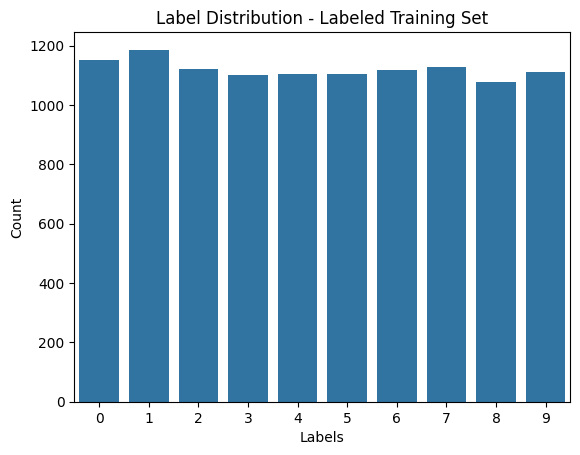

Minimum Pixel Value: -0.8101983666419983
Maximum Pixel Value: 2.022662878036499
Mean Pixel Value: -0.048925913870334625
Standard Deviation: 0.98920077085495
Minimum Pixel Value: 0.0
Maximum Pixel Value: 1.0
Mean Pixel Value: 0.2686415910720825
Standard Deviation: 0.3492022752761841


In [12]:
# # Compairing Feature Ranges after Data Preprocessing
# Specifically Z-score
label_distribution(labeled_training_set_zscore, "Labeled Training Set")
feature_image_range(labeled_training_set_zscore)

# Min MAx
feature_image_range(labeled_training_set)

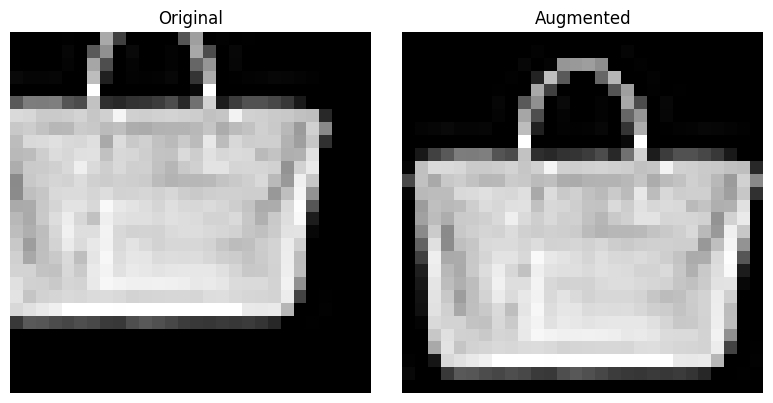

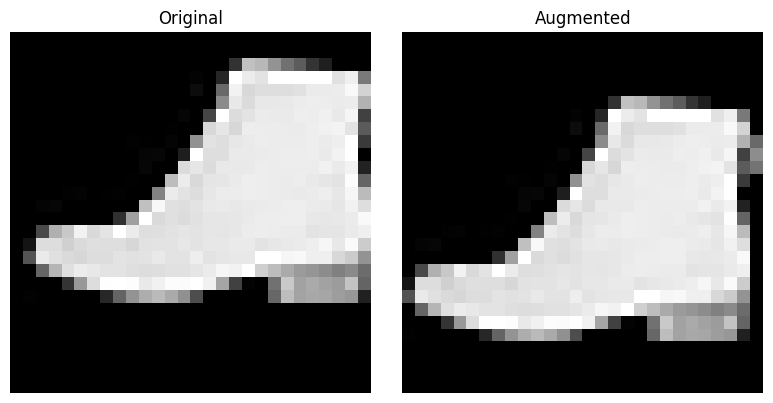

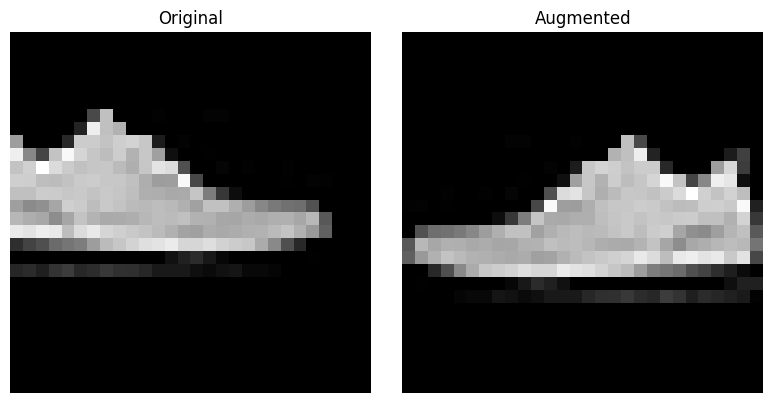

In [13]:
import numpy as np
# Presenting Images with Data augmentations

# Loop and show three random images with original and applied augmentations
for i in range(3):
  x = np.random.randint(0,len(labeled_training_set))
  original_img, augmented_img_minmax, augmented_label_minmax = labeled_training_set[i]

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

  ax1.imshow(original_img.squeeze(), cmap='gray')
  ax1.set_title(f'Original')
  ax1.axis('off')

  ax2.imshow(augmented_img_minmax.squeeze(), cmap='gray')
  ax2.set_title(f'Augmented')
  ax2.axis('off')

  plt.tight_layout()
  plt.show()


# Step 2: Building the Baseline Model Archetecture

In [14]:
class BaslineModelSemiSupervised(nn.Module):
  def __init__(self):
    super(BaslineModelSemiSupervised, self).__init__(number_of_classes = 10)

  def forward(self,x):
    return x